# CNN on CIFAR-10: Final Project ADTA 5550  Deep Learning With Big Data 

#  Yog Chaudhary 

## Set Path for Data Folder

In [69]:
 # Put file path as a string here

CIFAR_DIR = 'CIFAR_10_DATA/'

## Load Data

In [70]:
CIFAR_DIR

'CIFAR_10_DATA/'

In [71]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [72]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

all_data = [0,1,2,3,4,5,6]

for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [73]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [74]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [75]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

## Display several examples of single images using matplotlib 

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [77]:
X = data_batch1[b"data"] 

In [78]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [79]:
X[0].max()

255

In [80]:
(X[0]/255).max()

1.0

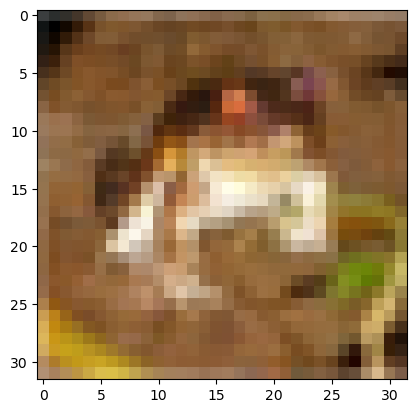

In [81]:
plt.imshow(X[0])

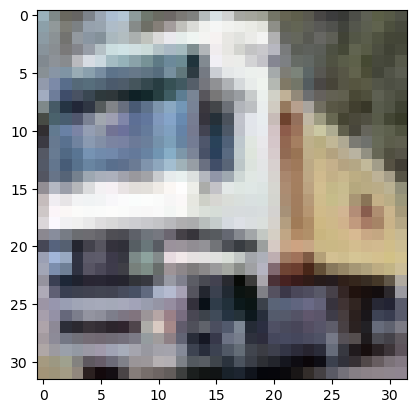

In [82]:
plt.imshow(X[1])

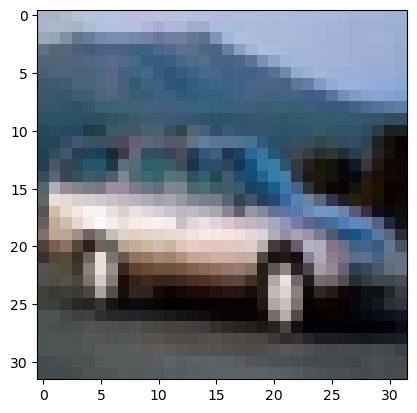

In [83]:
plt.imshow(X[4])

## Supporting Functions to Rearrange Data

### Encode Labels into One-Hot Format

In [84]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

## Set Up Image Data: Make it Ready to be Fed into 1st Conv Layer

In [85]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

## Set up image data: Calling CifarHelper.set_up_images()

In [86]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Define Supporting Functions to Build, Train, and Test CNN Model

In [87]:
# initialize weights is filter
def initialize_weights (filter_shape):
    init_random_dist = tf.truncated_normal(filter_shape, stddev=0.1)
    return(tf.Variable(init_random_dist))

In [88]:
# initialize bias
def initialize_bias(bias_shape):
    initial_bias_vals = tf.constant(0.1, shape=bias_shape)
    return(tf.Variable(initial_bias_vals))

In [89]:
# Setting up convolutional layer
def create_convolution_layer_and_compute_dot_product(inputs, filter_shape):
    filter_initialized_with_weights = initialize_weights(filter_shape)
    conv_layer_outputs = tf.nn.conv2d(inputs, filter_initialized_with_weights, strides=[1, 1, 1, 1], padding='SAME')
    return(conv_layer_outputs)

# PHASE I: Build Convolutional Neural Network

In [90]:
import tensorflow as tf

In [91]:
# Define a function
# First, to set up a ReLU layer: an activation function layer
# then, perform the computation: dot product + bias: (x*W)+b

# ReLU: Rectified Linear Unit - a popular activation function used in CNN
# In this layer, the bias has been initialized
# Paramters: 
# inputs - outputs from the preceding convolution layer: Dot product inputs * weights
# filter_shape:
# [filter H, filter W, in_channels(in_depth = in_num_filters), out_channels(out_depth = out_num_filters)]
# for example; [5, 5, 1, 32]

# Return: Outputs of the layer: dot product + b: (x * W) + b

def create_relu_layer_and_compute_dotproduct_plus_b(inputs, filter_shape):
    # Initialize bias for each input channel
    b = initialize_bias([filter_shape[3]])
    
    # Perform the computation first by adding: inputs (x*W)+b
    # Create a ReLU layer associated with the preceding convolution layer
    relu_layer_outputs = tf.nn.relu(inputs + b)
    
    # Return the putputs of the ReLU layer
    return(relu_layer_outputs)

In [92]:
# Set up a pooling layer and reduce spatial size
def create_maxpool2by2_and_reduce_spatial_size(inputs):
    pooling_layer_outputs = tf.nn.max_pool(inputs, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return(pooling_layer_outputs)

In [93]:
def create_fully_connected_layer_and_compute_dotproductt_plus_bias(inputs, output_size):
    input_size = int(inputs.get_shape()[1])
    w = initialize_weights([input_size, output_size])
    b = initialize_bias([output_size])
    fc_xW_plus_bias_outputs = tf.matmul(inputs, w) + b
    return(fc_xW_plus_bias_outputs)

## Create Placeholders for Inputs and Labels: x and y_true

In [94]:
# PLACEHOLDER

# Create a placeholder for the inputs data: x
# x: a 2D array
# x: a placeholder that can hold any number of rows/record

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

In [95]:
# PLACEHOLDER

# Create a placeholder for the labels of the inputs data: y_true
# y_true: a 2D array
# y_true: Can hold any number of rows/records

y_true = tf.placeholder(tf.float32, [None, 10])

In [96]:
# Prepare feeding inputs into the 1st conv layer
# Reshape the pnput x: A placeholder
# From 1D array (vector) -> Original input shape: 4D-input: [batch, H, W, depth channels]
# Depth = color channels: grey scale = 1
# Reshaped inputs: x_image: [ 1, 28, 28, 1]

#x_image = tf.reshape(x, [-1, 28, 28, 1])

## Reshape the Input Placeholder x: NOT NEED TO RESHAPE DATA HERE

In [97]:
# DO NOTHING -- DON'T NEED TO RESHAPE - DATA IS ALREADY IN GOOD SHAPE TO BE FED INTO 1ST CONVOLUTION LAYER

In [98]:
# Create 1st convolutional layer, ReLU layer, and perform computation
conv_layer_1_outputs = create_convolution_layer_and_compute_dot_product(x, filter_shape=[5, 5, 3, 32])
conv_relu_layer_1_outputs = create_relu_layer_and_compute_dotproduct_plus_b(conv_layer_1_outputs, filter_shape=[5, 5, 3, 32])

In [99]:
# Pooling 1st layer and reduce spatial layer
pooling_layer_1_outputs = create_maxpool2by2_and_reduce_spatial_size(conv_relu_layer_1_outputs)

In [100]:
# Create the 2nd convolutional layer
# Input: x_image:Reshaped inputs with shape [1, 28, 28, 1]
# filter_shape: [5, 5, 32, 64]
# filter: 5x5
# Input channels: 32
# Output channels: 64

# Create the 1st convolution layer
# then learn / extract the features, get the results(output): Dot product of inputs * weights
# return the outputs of the layer

conv_layer_2_outputs = create_convolution_layer_and_compute_dot_product(pooling_layer_1_outputs, filter_shape=[5, 5, 32, 64])

# Create the ReLU layer for the 1st convolution layer
# Accept the outputs from 1st conv layer as the inputs
# Returns the outputs of the layer

conv_relu_layer_2_outputs = create_relu_layer_and_compute_dotproduct_plus_b(conv_layer_2_outputs, filter_shape=[5, 5, 32, 64])

In [101]:
# 2nd pooling layer and reduce spatial size
pooling_layer_2_outputs = create_maxpool2by2_and_reduce_spatial_size(conv_relu_layer_2_outputs)

In [102]:
conv_layer_3_outputs = create_convolution_layer_and_compute_dot_product(pooling_layer_1_outputs, filter_shape=[5, 5, 32, 64])

conv_relu_layer_3_outputs = create_relu_layer_and_compute_dotproduct_plus_b(conv_layer_2_outputs, filter_shape=[5, 5, 32, 64])

In [103]:
pooling_layer_3_outputs = create_maxpool2by2_and_reduce_spatial_size(conv_relu_layer_3_outputs)

## Create 1st Convolution Layer and so on .............

In [104]:
# Reshaping / flattening data
pooling_layer_3_outputs_flat = tf.reshape(pooling_layer_3_outputs, shape=[-1, 8 * 8 * 64])

In [105]:
# 1st FC layer 
fc_layer_1_outputs = create_fully_connected_layer_and_compute_dotproductt_plus_bias(pooling_layer_3_outputs_flat, output_size=1024)
fc_relu_layer_1_outputs = tf.nn.relu(fc_layer_1_outputs)

In [106]:
# Dropout layer and dropout a fraction of outputs randomly
hold_prob = tf.placeholder(tf.float32)
fc_dropout_outputs = tf.nn.dropout(fc_relu_layer_1_outputs, keep_prob=hold_prob)

In [107]:
# Create the final FC layer
# then compute: x*W + b
# Parameters:
# fc_dropout_outputs: Outputs from the dropout layer

# Return y_pred: final predicted outputs, i.e., final classification outputs
y_pred = create_fully_connected_layer_and_compute_dotproductt_plus_bias(fc_dropout_outputs, output_size=10)

In [108]:
# Define loss function: cross-entropy with logits, i.e., with the final outputs
# Calculate the softmax cross-entropy loss

softmax_cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

# Compute the mean of losses
cross_entropy_mean = tf.reduce_mean(softmax_cross_entropy_loss)

In [109]:
# Get an ADAM optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

In [110]:
# Create a CNN model trainer that can train the model
# And optimize the model by minimizing the softmax cross_entropy loss

cnn_trainer = optimizer.minimize(cross_entropy_mean)

In [111]:
# Get a variable initializer

vars_initializer = tf.global_variables_initializer()

# PHASE II: Train and Test CNN Model on CIFAR-10 Dataset

In [112]:
# x: CIFAR-10.train: 50000 images
# Each time of training (run the whole process) = 1 step
# Each time of training: use one batch of inputs

# Steps = 5000: Fininsh the training after running 5000 times

steps = 5000

In [113]:
with tf.Session() as sess:
    # First, run vars_initializer to initialize
    sess.run(vars_initializer)
    
    for i in range(steps):
        # Each batch: 100 images
        batch = ch.next_batch(100)
        
        # Train the model
        # Dropout keep_prob (% to keep): 0.5 --> 50% will be dropped out
        sess.run(cnn_trainer, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
        # Test the model: at each 100th step
        # Run this block of code for each 100 times of training, each time run a batch 
        if i % 100 == 0:
            print('ON STEP: {}'.format(i))
            print('ACCURACY: ')
            
            # Compare to find matches of y_pred and y_true
            matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
            
            # Cast the matches from integers to tf.float32
            # Calculate the accuracy using the mean of matches
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            
            # Test the model at each 100th step
            # Using test dataset
            # Dropout: NONE because of test, not training
            test_accuracy = sess.run (acc, feed_dict = {x:ch.test_images, y_true: ch.test_labels, hold_prob: 1.0})
            print(test_accuracy)
            print('\n')

ON STEP: 0
ACCURACY: 
0.1003


ON STEP: 100
ACCURACY: 
0.3978


ON STEP: 200
ACCURACY: 
0.4549


ON STEP: 300
ACCURACY: 
0.4896


ON STEP: 400
ACCURACY: 
0.4925


ON STEP: 500
ACCURACY: 
0.5377


ON STEP: 600
ACCURACY: 
0.5504


ON STEP: 700
ACCURACY: 
0.5688


ON STEP: 800
ACCURACY: 
0.578


ON STEP: 900
ACCURACY: 
0.5741


ON STEP: 1000
ACCURACY: 
0.6066


ON STEP: 1100
ACCURACY: 
0.5883


ON STEP: 1200
ACCURACY: 
0.5966


ON STEP: 1300
ACCURACY: 
0.5996


ON STEP: 1400
ACCURACY: 
0.6194


ON STEP: 1500
ACCURACY: 
0.6357


ON STEP: 1600
ACCURACY: 
0.6319


ON STEP: 1700
ACCURACY: 
0.6124


ON STEP: 1800
ACCURACY: 
0.6333


ON STEP: 1900
ACCURACY: 
0.6339


ON STEP: 2000
ACCURACY: 
0.6463


ON STEP: 2100
ACCURACY: 
0.6415


ON STEP: 2200
ACCURACY: 
0.649


ON STEP: 2300
ACCURACY: 
0.654


ON STEP: 2400
ACCURACY: 
0.648


ON STEP: 2500
ACCURACY: 
0.6589


ON STEP: 2600
ACCURACY: 
0.6485


ON STEP: 2700
ACCURACY: 
0.6681


ON STEP: 2800
ACCURACY: 
0.6572


ON STEP: 2900
ACCURACY: 
0.658